In [1]:
#%load_ext autoreload
#%autoreload 2

import os
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
import h5py

import numpy as np
import torch
from ssl_legacysurvey.utils import load_data # Loading galaxy catalogue and image data from hdf5 file(s)
from ssl_legacysurvey.utils import plotting_tools as plt_tools # Plotting images or catalogue info

from ssl_legacysurvey.data_loaders import datamodules # Pytorch dataloaders and datamodules
from ssl_legacysurvey.data_loaders import decals_augmentations # Augmentations for training

from ssl_legacysurvey.data_analysis import dimensionality_reduction # PCA/UMAP functionality
import matplotlib.pyplot as plt
print("Current working directory: {0}".format(os.getcwd()))

data_path = '/pscratch/sd/s/sgmoore1/ssl-legacysurvey/data/disk_listed_offsets.h5'


Current working directory: /pscratch/sd/s/sgmoore1/ssl-legacysurvey


In [2]:
# Define matplotlib defaults
plt.rcParams['figure.figsize']        = 8., 6.
plt.rcParams['axes.labelsize']        = 18
plt.rcParams['axes.titlesize']        = 18
plt.rcParams['xtick.top']             = True
plt.rcParams['xtick.bottom']          = True
plt.rcParams['ytick.left']            = True
plt.rcParams['ytick.right']           = True
plt.rcParams['xtick.direction']       = 'in'
plt.rcParams['ytick.direction']       = 'in'
plt.rcParams['xtick.labelsize']       = 18
plt.rcParams['ytick.labelsize']       = 18
plt.rcParams['xtick.major.pad']       = 6.
plt.rcParams['xtick.minor.pad']       = 6.
plt.rcParams['ytick.major.pad']       = 6.
plt.rcParams['ytick.minor.pad']       = 6.
plt.rcParams['xtick.major.size']      = 6. # major tick size in points
plt.rcParams['xtick.minor.size']      = 3. # minor tick size in points
plt.rcParams['ytick.major.size']      = 6. # major tick size in points
plt.rcParams['ytick.minor.size']      = 3. # minor tick size in points
plt.rcParams['text.usetex']           = False
plt.rcParams['font.family']           = 'serif'
plt.rcParams['font.size']             = 18
    

In [3]:
# with h5py.File(data_path, 'a') as hf:
    # umap_region = hf.create_dataset('umap_region',(3428,), maxshape=(None,))

In [4]:
# Load h5py file into dictionary
DDL = load_data.DecalsDataLoader(image_dir=data_path, npix_in=152)

gals = DDL.get_data(-1, fields=DDL.fields_available,npix_out=152) # -1 to load all galaxies

print("Available keys & data shapes:")
for k in gals:
    print(f"{k} shape:", gals[k].shape)

Available keys & data shapes:
inds shape: (10999,)
cutout_type shape: (10999,)
dec shape: (10999,)
images shape: (10999, 3, 152, 152)
mag_g shape: (10999,)
mag_r shape: (10999,)
mag_z shape: (10999,)
offset shape: (10999,)
ra shape: (10999,)
umap_region shape: (10999,)


In [5]:
# # Display some pretty galaxy pictures
# nplt = 50
# ncol = 5

# npix_show = 96

# # Display images in grid, with ra/dec for each galaxy. Colors are after grb transformation, not raw data
# print('Original:')
# plt_tools.show_galaxies(gals['images'][500:],
#                         gals['ra'][500:], gals['dec'][500:], 
#                         nx=ncol, nplt=nplt, npix_show=npix_show)
# #plt.savefig('figures/centered_gals.png')

In [6]:
# Import necessary modules for self-supervised learning 
# To prevent OpenBLAS blas_thread_init
# os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
import torch
import torchvision
import pytorch_lightning as pl
import h5py

import argparse
import logging

from pathlib import Path
import os
import sys
import glob
import math

from pytorch_lightning import loggers as pl_loggers
# from pl_bolts.models.self_supervised import Moco_v2
from pytorch_lightning.plugins import DDPPlugin
#strategy = 'ddp'
from ssl_legacysurvey.moco.moco2_module import Moco_v2 

from ssl_legacysurvey.data_loaders import datamodules
from ssl_legacysurvey.utils import format_logger
from scripts import predict
from ssl_legacysurvey.finetune import extract_model_outputs
from scripts import similarity_search_nxn

In [7]:
class Args: # In general codes in this project use argparse. Args() simplifies this for this example 
    # Data location and GPU availability 
    data_path = '/pscratch/sd/s/sgmoore1/ssl-legacysurvey/data/disk_listed_offsets.h5'
    gpu = True # Use GPU?
    gpus = 1 # Number of gpus to use
    num_nodes = 1
    ngals_tot = gals['images'].shape[0]
    # Training
    verbose = True
    ssl_training = True
    batch_size = ngals_tot
    learning_rate = 0.03
    max_epochs = 5
    max_num_samples= ngals_tot
    
    
    check_val_every_n_epoch = 999 # We haven't provided validation set, so don't use it!
    num_sanity_val_steps = 0

    augmentations = 'grrrssgbjcgnrg'
    jitter_lim = 7
    
    strategy = 'dp' # Distributed training strategy,  ddp does not work in ipython notebook, only dp does
    seed = 13579

    checkpoint_every_n_epochs = 1
    num_workers = 1 # Number of workers for data loader

    # Model architecture and settings
    backbone = 'resnet50' # Encoder architecture to use, Can use any in torchvision, i.e. ['resnet18', 'resnet34', 'resnet50', 'resnet152', .....]
    use_mlp = True # use projection head

    emb_dim = 128 # Dimensionality where loss is calculated
    num_negatives = 16 #Number of negative samples to keep in queue for Mocov2
    
    # needed for predict.py script
    out_dir = 'diskdata/representations/'
    extract_representations = True
    checkpoint_path = 'resnet50.ckpt'
    use_mlp_representation = True
    overwrite = True
    file_head = 'diskdata'
    chunksize= ngals_tot
    batch_size_per_gpu = int(gals['images'].shape[0]/4)
    num_gpus = 1
    data_dim = 2048
    predict_batch_size = ngals_tot
    representation_directory = 'diskdata/representations/'
    representation_file_head = file_head
    umap_file_head = 'umap_diskdata_representations'
    train_umap = True
    
    #For dimensionality reduction script
    n_samples = 1000
    sample_dimensionality = 100
    n_pca_components = 8
    n_umap_components = 2
    umap_embedding_file_path = os.path.join(out_dir, f"{umap_file_head}_{gals['images'].shape[0]}_embedding.npz")
    umap_transform_file_path = os.path.join(out_dir, f"{umap_file_head}_{gals['images'].shape[0]}_transform.pkl")

    #for similarity search:
    use_faiss = True
    use_gpu = True
    norm = True
    
    rep_dir = 'diskdata/representations/compiled/'
    output_dir = 'diskdata/representations/similarity/'
    knearest = 25
    delta_mag = 20
    start_on_chunk = 0
    survey = 'south'
    rep_file_head = file_head
    decals_dir = '/global/cfs/projectdirs/cusp/LBL/decals_galaxy_survey/'
    chunksize_similarity = ngals_tot
    sim_chunksize= ngals_tot
    rep_dim = 128
    nchunks = int(math.ceil(ngals_tot/chunksize))
    nchunks_similarity = int(math.ceil(ngals_tot/chunksize_similarity))
    supervised_training = True
    #batch_indices = [range(0,ngals_tot)]
    
params = vars(Args)
p = {}
for k, v in params.items():
    p[k] = v
params = p

In [8]:
model = Moco_v2.load_from_checkpoint(
        checkpoint_path=params['checkpoint_path']
        )

# #Generate model from checkpoint
# model = Moco_v2(
#     base_encoder=params['backbone'],
#     emb_dim=params['emb_dim'],
#     use_mlp=params['use_mlp'],
#     learning_rate=params['learning_rate'],
#     batch_size=params['batch_size'],
# )
# datamodule = datamodules.DecalsDataModule(params)
# #checkpoint_path = 'resnet50.ckpt'
# trainer = pl.Trainer()
# model = model.load_from_checkpoint(params['checkpoint_path'])

In [9]:
#from scripts import predict
# Set self-supervised encoder as out backbone
backbone = model.encoder_q

# Remove the MLP projection head from the model, so output is now the representaion for each galaxy
backbone.fc = torch.nn.Identity()

params['ssl_training'] = False
params['jitter_lim'] = 0
params['augmentations'] = 'rrjc'#adjust to whatever parameters you want

# Load all images as one batch

transform = datamodules.DecalsTransforms(
    params['augmentations'],
    params
)


decals_dataloader = datamodules.DecalsDataset(
    data_path,
    None,
    transform,
    params,
)
#ngals = (4096+4096+128) #use when doing a subset/regenerating images without the sga-missing catalog
ngals =  gals['images'].shape[0]
im, label = decals_dataloader.__getitem__(0)
images = torch.empty((ngals, im.shape[0], im.shape[1], im.shape[2]), dtype=im.dtype)
for i in range(ngals):
    images[i], _ = decals_dataloader.__getitem__(i)
    

In [10]:
# Run images through model to get representations
representations = backbone(images)

In [11]:
# #Code pulled from predict.py script and modified in order so it would actually run

# #params['supervised_training'] = True
# Path(params['out_dir']).mkdir(parents=True, exist_ok=True)
# #params['predict'] = not params['extract_representations'] # if not extracting representations then must want model predictions

# if params['verbose']:
#     print("\nTraining with the following parameters:")
#     for k, v in params.items():
#         print(k, v)
# if params['extract_representations']: 
#     # Do not need any classification head, just SSL trained model
#     moco_model = Moco_v2.load_from_checkpoint(
#         checkpoint_path=os.path.join(params['checkpoint_path'])
#         )
#     # extract encoder_q from Moco_v2 model
#     backbone = moco_model.encoder_q
#     if not params['use_mlp_representation']:
#         try:
#             # check if model does not use mlp projection head
#             emb_dim = backbone.fc.in_features
#         except:
#             # Model does use mlp projection head
#             emb_dim = backbone.fc[0].in_features
#         # Remove projection head by setting to Identity layer
#         backbone.fc = torch.nn.Identity()
#     else:
#         emb_dim = params['emb_dim']
#     print(f"Representation dimensionality to be extracted: {emb_dim}")
#     model = extract_model_outputs.OutputExtractor(backbone)

# # commented out because it caused some problems and I was only using this cell to extract the representations
#     # else:
# #     model = finetuning.SSLFineTuner.load_from_checkpoint(
# #         checkpoint_path=params['checkpoint_path'],
# #         )
# # if params['verbose']:
# #     print(model)
# datamodule = datamodules.DecalsDataModule(params)
# datamodule.setup(stage="predict")
# # Predictions are written during trainer.predict by this callback
# prediction_dir = os.path.join(params['out_dir'], 'chunks/')
# Path(prediction_dir).mkdir(parents=True, exist_ok=True)
# # Clear previous files so chunks don't get incorrectly compiled
# previous_files = glob.glob(prediction_dir + "*")
# for f in previous_files:
#     os.remove(f)

# PredictionWriterCallback = extract_model_outputs.OutputWriter(
#     prediction_dir,
#     file_head=params['file_head'],
#     overwrite=params['overwrite'],
#     write_interval="batch",
# )

# strategy = params['strategy']
# trainer = pl.Trainer.from_argparse_args(
#     Args,
#     strategy=strategy,
#     callbacks=[PredictionWriterCallback],
# )
# print("Predicting over dataset")

# #Predict over dataset and save each batch to disk                 
# preds = trainer.predict(
#     model,
#     datamodule=datamodule,
#     return_predictions=False, # On such a large dataset storing full predictions will crash, so write in batches
# )


# print("DEBUG", torch.cuda.current_device())

In [12]:
# # Compile batches into final file
# if torch.cuda.current_device() == 0:
#     print('Saving compiled file:')
#     predict.compile_chunks(params)

In [13]:
# x = np.load('/pscratch/sd/s/sgmoore1/ssl-legacysurvey/cutoutdata/representations/chunks/cutoutdata_batch_0000000_000.npz')
# np.set_printoptions(threshold=sys.maxsize)
# x['data']

In [14]:
# #similarity search, 

# params = vars(Args)
# Path(params['output_dir']).mkdir(parents=True, exist_ok=True)
# # params['use_faiss'] = True
# # params['use_gpu'] = True
# # params['norm'] = True # normalize vector lengths
# if not params['use_faiss']:
#     params['use_gpu'] = False
# #params['chunksize'], params['rep_dim'], ngals_tot = similarity_search_nxn.get_dataset_size(params)
# print(params['chunksize'], params['rep_dim'], params['ngals_tot'])
# #params['ngals_tot'] = min(params['ngals_tot'], ngals_tot)

# print(f"\nNumber of galaxies={params['ngals_tot']}, chunksize={params['chunksize']}, representation_dim={params['rep_dim']}\n")
# # load in representations in chunks
# #params['nchunks'] = int(math.ceil(params['ngals_tot']/params['chunksize']))
# #params['nchunks_similarity'] = int(math.ceil(params['ngals_tot']/params['chunksize_similarity'])) + 1
# # Search within certain magnitude range of queries requires magnitude
# DDL = load_data.DecalsDataLoader(image_dir=params['data_path'])
# print("\nloading flux of all galaxies in survey. Be patient.\n")
# zmag = gals['mag_z']
# for ichunk_similarity in range(params['start_on_chunk'], params['nchunks_similarity']):
#     print('Running on query chunk: ', ichunk_similarity)

#     rep_query_start = ichunk_similarity*params['chunksize_similarity']
#     rep_query_end = min(rep_query_start+params['chunksize_similarity'], params['ngals_tot'])
#     print(rep_query_start , rep_query_end)
#     inds_file_out = os.path.join(
#         params['output_dir'],
#         f"inds_knearest{params['knearest']:03d}_{rep_query_start:09d}_{rep_query_end:09d}.npy",
#         )
    
#     dist_file_out = os.path.join(
#         params['output_dir'],
#         f"dist_knearest{params['knearest']:03d}_{rep_query_start:09d}_{rep_query_end:09d}.npy",
#         )
#     file_exists = os.path.isfile(inds_file_out) and os.path.isfile(dist_file_out)
#     if not params['overwrite'] and file_exists:
#         continue
    
#     np.save(inds_file_out, np.array([0])) # create output file first
#     np.save(dist_file_out, np.array([0]))

#     #inds_query = np.arange(rep_query_start, rep_query_end)
#     inds_query = np.arange(0, params['ngals_tot'])
#     rep_query = similarity_search_nxn.load_representatons_by_inds(params, inds_query) # load representations to query for
#     # Narrow search size by galaxy magnitude
#     zmag_min = zmag[inds_query[0]] - params['delta_mag']
#     zmag_max = zmag[inds_query[-1]] + params['delta_mag']
#     ind_min, zmag_min = similarity_search_nxn.find_nearest(zmag, zmag_min)
#     ind_max, zmag_max = similarity_search_nxn.find_nearest(zmag, zmag_max)
#     chunk_min = ind_min // params['chunksize']
    
#     chunk_max = math.ceil(ind_max / params['chunksize'])
#     print(f'Magnitude range runs from index {ind_min}-{ind_max} (chunks {chunk_min}-{chunk_max})')
#     # Now perform similarity search chunk by chunk
#     # will return distance and index arrays of size (nquery, k)
#     similarity_indexes, distance = similarity_search_nxn.calculate_similarity_for_chunk(params, rep_query, chunk_min, chunk_max)
#     np.save(inds_file_out, similarity_indexes)
#     np.save(dist_file_out, distance)

In [15]:
#x = similarity_search_nxn.load_rep_chunk('/pscratch/sd/s/sgmoore1/ssl-legacysurvey/cutoutdata/representations/compiled/cutoutdata_000000000_000005628.npy')

In [16]:
# x = np.load('/pscratch/sd/s/sgmoore1/ssl-legacysurvey/cutoutdata/representations/similarity/inds_knearest1000_000000000_000005628.npy')
# np.set_printoptions(threshold=sys.maxsize)
# x

In [17]:
# y = np.load('/pscratch/sd/s/sgmoore1/ssl-legacysurvey/cutoutdata/representations/similarity/dist_knearest1000_000000000_000005628.npy')
# cleaner = np.around(y, decimals=3)
# cleaner


In [18]:
# x = np.load('/pscratch/sd/s/sgmoore1/ssl-legacysurvey/representations/similarity/inds_knearest025_000000000_000000064.npy')
# #np.set_printoptions(threshold=sys.maxsize)
# print(x)

In [19]:
# y = np.load('/pscratch/sd/s/sgmoore1/ssl-legacysurvey/representations/similarity/dist_knearest010_000000000_000000008.npy')
# np.set_printoptions(threshold=sys.maxsize)
# print(y[0:8])

In [11]:
# Move pytorch tensors to CPU (if on GPU) and to numpy

if params['gpu']:
    images, representations = images.detach(), representations.detach()
images, representations = images.numpy(), representations.numpy()

In [21]:
# #np.random.seed(13579)
# nplt = 1
# inds_plt = np.arange(images.shape[0])
# inds_plt = sorted(np.random.choice(inds_plt, min(nplt, inds_plt.shape[0]), replace=True))

# for i in inds_plt:
#     fig, ax = plt.subplots(1, 2, figsize=(10,4))
    
#     imi, repi = images[i], representations[i]
    
#     ax[0].imshow(np.swapaxes(imi, 0, 2))
#     ax[1].plot(repi)
#     ax[0].set_title("Input image")
#     ax[1].set_title("Output Representation")


In [12]:
from ssl_legacysurvey.data_analysis import dimensionality_reduction
from ssl_legacysurvey.utils import plotting_tools as plt_tools # Plotting images or catalogue info

#pca_components, rep_pca, pca = dimensionality_reduction.pca_transform(representations, n_components=2)
#Adjusted to create separate embeddings for the different distance metrics
umap_embedding_cos, umap_trans_cos = dimensionality_reduction.umap_transform(representations, n_components=2, metric='cosine')
#umap_embedding_euc, umap_trans_euc = dimensionality_reduction.umap_transform(representations, n_components=2, metric='euclidean')

UMAP embedding is shape (10999, 2)


In [23]:
#f = h5py.File('/pscratch/sd/s/sgmoore1/ssl-legacysurvey/data/representations.h5','a')

In [24]:
# count= ngals
# dim= 2048
# reps = f.create_dataset('representations',(count,dim,), maxshape=(None,None,))


In [25]:
# i=0
# while i < ngals:
#     reps[i] = representations[i]
#     i+=1

In [26]:
# f = h5py.File('/pscratch/sd/s/sgmoore1/ssl-legacysurvey/data/representations.h5','a').close

In [27]:
# f = h5py.File('/pscratch/sd/s/sgmoore1/ssl-legacysurvey/data/representations.h5','r')

In [28]:
# # Look at PCA decomposition

# plt.figure()
# plt.scatter(pca_components[:5500, 0], pca_components[:5500, 1], s=10, c='purple', label = 'Galaxies')
# plt.scatter(pca_components[5500:, 0], pca_components[5500:, 1],s=10, c='orange', label = 'Blank Sky')
# plt.xlabel('Dimension 0')
# plt.ylabel('Dimension 1')
# plt.title('PCA components, Colored by Cutout Type')
# plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,loc='lower right',markerscale=3)
# #plt.savefig('figures/sample_pca.png')

# # Plot as images in a fancy plot
# # nx, ny = 15,15
# # inds_use = np.arange(images.shape[0])
# # im = plt_tools.scatter_plot_as_images(DDL, pca_components, inds_use, nx=nx, ny=ny, npix_show=96)


In [29]:
# lbl= np.empty(ngals, dtype=object)
# print(len(label))
# i=0
# while i < ngals:
#     if gals['cutout_type'][i] == 1:
#         lbl[i] = 'Centered'
#     elif gals['cutout_type'][i] == 2:
#         lbl[i] = 'Off-Centered'
#     elif gals['cutout_type'][i] == 3:
#         lbl[i] = 'Blank Sky'
#     i+=1
# print(lbl)
# # print(gals['cutout_type'])
# # = 'Centered'
# # gals['cutout_type'][gals['cutout_type'] == 2] = 'Off-Centered'
# # gals['cutout_type'][gals['cutout_type'] == 3] = 'Blank Sky'
# x = np.unique(lbl)


In [30]:
#If cutout types weren't loaded together into the h5 file, 
#need to run this in order for the UMAP to separate into chunks that can be easily indexed

#gals['cutout_type'].sort()

In [31]:
#determine the bounds for the UMAP chunks
# unique, counts = np.unique(gals['cutout_type'], return_counts = True)
# print(unique, counts)

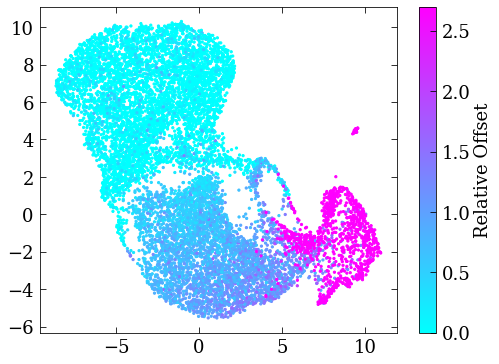

In [22]:
# # Look at UMAP embedding
#plt.rcParams['axes.titlesize'] = 24
plt.figure()
plt.scatter(umap_embedding_cos[:, 0], umap_embedding_cos[:, 1],s=5, c=gals['offset']
           )

# plt.scatter(umap_embedding_euc[:, 0], umap_embedding_euc[:, 1],s=10, c=gals['mag_z']
#            )

#Split up the scatterplots into chunks of the same cutout_type so that labels can be given for each color

# plt.scatter(umap_embedding_cos[:5000, 0], umap_embedding_cos[0:5000, 1],s=5, c='#3c1361', label = 'Centered'
#            )
# plt.scatter(umap_embedding_cos[5000:10000, 0], umap_embedding_cos[5000:10000, 1],s=5, c='#5BB450', label = 'Off-Centered'
#            )
# plt.scatter(umap_embedding_cos[10000:, 0], umap_embedding_cos[10000:, 1],s=5, c='#0044FF', label = 'Blank Sky'
#            )

# plt.scatter(umap_embedding_cos[5095:, 0], umap_embedding_cos[5095:, 1],s=5, c='#5BB450', label = 'Missing Galaxies'
#           )

# plt.scatter(umap_embedding_cos[8320:, 0], umap_embedding_cos[8320:, 1],s=10, c='#02198B', label = 'SGA-missing'
#            )

# alternate colors #FDFD66
# plt.xlabel('Dimension 0')
# plt.ylabel('Dimension 1')
#Adjust bounds so that legend can display without covering up data
# plt.xlim(-7)
# plt.ylim(-8)
# plt.title('UMAP with Blank Sky Images')
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,loc='best',markerscale=5, fontsize=16)
#plt.savefig('figures/hr_offsets.png',dpi=400)


# # Plot as images in a fancy plot

# nx, ny = 60,40
# inds_use = np.arange(images.shape[0])
# im = plt_tools.scatter_plot_as_images(DDL, umap_embedding_cos, inds_use, nx=nx, ny=ny, npix_show=96)
plt.savefig('figures/colorbar_gals_offsets.png', dpi=400)

In [ ]:
# plt.figure()
# plt.scatter(umap_embedding_euc[:, 0], umap_embedding_euc[:, 1],s=10, c=gals['morphology']
#            )

# nx, ny = 60,40
# inds_use = np.arange(images.shape[0])
# im = plt_tools.scatter_plot_as_images(DDL, umap_embedding_euc, inds_use, nx=nx, ny=ny, npix_show=96)
# plt.savefig('figures/gals_euc.png')

In [ ]:
# # # Look at UMAP embedding
# plt.figure()
# plt.scatter(umap_embedding_cos[:5500, 0], umap_embedding_cos[:5500, 1],s=10, c='purple', label = 'Galaxies'
#            )
# plt.scatter(umap_embedding_cos[5500:, 0], umap_embedding_cos[5500:, 1],s=10, c='orange', label = 'Blank Sky'
#            )

# # plt.scatter(umap_embedding_euc[:, 0], umap_embedding_euc[:, 1],s=10, c=gals['mag_z']
# #            )

# #Split up the scatterplots into chunks of the same cutout_type so that labels can be given for each color

# # plt.scatter(umap_embedding_cos[0:10000, 0], umap_embedding_cos[0:10000, 1],s=10, c='#3c1361', label = 'SGA Galaxies'
# #            )
# # plt.scatter(umap_embedding_cos[10000:10999, 0], umap_embedding_cos[10000:10999, 1],s=10, c='#0044FF', label = 'Blank Sky'
# #            )
# # plt.scatter(umap_embedding_cos[10999:, 0], umap_embedding_cos[10999:, 1],s=10, c='#5BB450', label = 'SGA-missing'
# #            )
# # plt.scatter(umap_embedding_cos[8320:, 0], umap_embedding_cos[8320:, 1],s=10, c='#02198B', label = 'SGA-missing'
# #            )

# # alternate colors #FDFD66
# plt.xlabel('Dimension 0')
# plt.ylabel('Dimension 1')
# #Adjust bounds so that legend can display without covering up data
# #plt.xlim()
# #plt.ylim(-10.5)
# plt.title('UMAP Embedding, Colored by Cutout Type')

# plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,loc='best',markerscale=3)
# #plt.savefig('figures/sample_UMAP.png')


# # # Plot as images in a fancy plot

# # nx, ny = 10,10
# # inds_use = np.arange(images.shape[0])
# # im = plt_tools.scatter_plot_as_images(DDL, umap_embedding_cos, inds_use, nx=nx, ny=ny, npix_show=96)

In [ ]:
#classify whether or not a given cutout is a galaxy based on where it falls within the UMAP
#Need to adjust the parameters for the threshold based on the shape of the UMAP
# i=0
# while i < ngals:
#     if umap_embedding_cos[i, 0] < 6:
#         gals['umap_region'][i] = 1
#     else:
#         gals['umap_region'][i] = 0
#     i+=1

In [ ]:
# #determine number of false positives and false negatives as well as information about the problematic cutouts
# i=0 
# false_pos = 0
# false_neg = 0
# while i < ngals:
#     if gals['cutout_type'][i] == 2:
#         if umap_embedding_cos[i, 0] < 8:
#             false_pos +=1
#             print('False positive galaxy has coordinates: ',gals['ra'][i],' , ',gals['dec'][i], 'and is gal ',i)
            
#     else:
#         if umap_embedding_cos[i, 0] > 8:
#             false_neg +=1
#             print('False negative galaxy has coordinates: ',gals['ra'][i],' , ',gals['dec'][i], 'and is gal ',i)
#     i+=1
        

In [ ]:
# i=0 
# sga_wrong=0
# while i < ngals:
#     if gals['cutout_type'][i] == 1:
#         if umap_embedding_cos[i, 0] > 6:
#             sga_wrong +=1
#     i+=1

In [ ]:
# print(sga_wrong)

In [ ]:
# print(false_pos)
# print(false_neg)

In [ ]:
# unique, counts = np.unique(gals['umap_region'], return_counts = True)
# print(unique, counts)

In [ ]:
# from scripts import similarity_search_nxn

In [ ]:
# params['rep_dir'] = data_path
# params['rep_file_head'] = "representations"
# size = similarity_search_nxn.get_dataset_size(params)

In [ ]:
# from umap import validation

# K = 50

# # trustworthiness_euc = validation.trustworthiness_vector(source=representations
# #                                   ,embedding=umap_embedding_euc                     
# #                                   ,max_k=55)

# trustworthiness_cos = validation.trustworthiness_vector(source=representations
#                                    ,embedding=umap_embedding_cos                    
#                                    ,max_k=55)

# _=plt.plot(trustworthiness_cos)
# #_=plt.plot(trustworthiness_euc)
# #_=plt.xlim(45,55)
# _=plt.xlabel("Value of K")
# _= plt.ylabel(f"Trustworthiness score")
# #_=plt.ylim(0.5,0.9)
# _=plt.title(f"Trustworthiness around k={K}")
# #_=plt.legend(["augmentations = rrjc", "augmentations = jcrg"], loc="upper right")

In [ ]:
import shutil

old = r'/pscratch/sd/s/sgmoore1/ssl-legacysurvey/Pretrained.ipynb'
new = r'/pscratch/sd/s/sgmoore1'

shutil.move(old, new)